### 0. Import und Globale Settings

In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pingouin as pg
import pandas as pd
import numpy as np
import scipy.stats as st
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns

from config_paths import DATASET_PATH

pd.set_option("display.max_columns", None)

position_mapping = {
    "TW": "Torwart",
    
    "IVR": "Innenverteidiger",
    "IVZ": "Innenverteidiger",
    "IVL": "Innenverteidiger",
    "RV": "Aussenverteidiger",
    "LV": "Aussenverteidiger",
    "DRM": "Aussenverteidiger",
    "DLM": "Aussenverteidiger",
    
    "DMR": "Defensives Mittelfeld",
    "DMZ": "Defensives Mittelfeld",
    "DML": "Defensives Mittelfeld",
    "RM": "Offensive Aussenbahn",
    "LM": "Offensive Aussenbahn",
    "HR": "Offensives Mittelfeld",
    "HL": "Offensives Mittelfeld",
    "ZO": "Offensives Mittelfeld",
    "ORM": "Offensive Aussenbahn",
    "OLM": "Offensive Aussenbahn",
    
    "RA": "Stürmer",
    "LA": "Stürmer",
    "STR": "Stürmer",
    "STZ": "Stürmer",
    "STL": "Stürmer"
}

### 1. Daten aus Dateien laden und Preprocessing

#### Dataframe für DAS-Daten aufbereiten

In [4]:
# Ergebnis der DAS-Potential Berechnung in data
import_data = import_data = pd.read_csv("output/df_player_list.csv")
import_data["position_group"] = import_data["position"].map(position_mapping)
data = import_data[["game_id", "player_id", "frame", "DAS_potential", "DAS_potential_percentage", "id", "full_name", "position", "team", "position_group", "DAS"]].copy()

# Halbzeiten ergänzen
temp_game_frames = data[["game_id", "frame"]].drop_duplicates().sort_values(by=["game_id", "frame"]).reset_index(drop=True)
temp_game_frames["diff"] = temp_game_frames.groupby("game_id")["frame"].diff()
temp_max_diff_per_game = (
    temp_game_frames.groupby("game_id")["diff"].max().reset_index()
)
temp_half_frames = (
    temp_game_frames[
        (temp_game_frames["game_id"].isin(temp_max_diff_per_game["game_id"])) & (temp_game_frames["diff"]).isin(temp_max_diff_per_game["diff"])
    ][["game_id", "frame"]]
)
data = data.merge(temp_half_frames, on="game_id", how="left", suffixes=(None, "_half"))
data["period"] = np.where(
    data["frame"] < data["frame_half"],
    1,
    2
)

frame_count = data.groupby("game_id")["frame"].nunique().reset_index()



#### Dataframe für Event-Daten aus XML bilden

In [5]:
from streamlit import dataframe


def extract_tracking_events_from_xml(xml_path, game_id):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    rows = []
    
    def get_attr(elem, name, default=None):
        return elem.attrib[name] if name in elem.attrib else default
    
    for event in root.iter("Event"):
        event_time = get_attr(event, "EventTime")
        x = float(get_attr(event, "X-Position", "0"))
        y = float(get_attr(event, "Y-Position", "0"))
        event_id = get_attr(event, "EventId")
        
        
        for elem in event.iter():
            tag = elem.tag
            if tag in ["BallClaiming"]:
                player_id = get_attr(elem, "Player")
                type = get_attr(elem, "Type")
                rows.append([game_id, player_id, "BallClaiming", type])
                
            if tag in ["BlockedShot"]:
                player_id = get_attr(elem, "Player")
                type = get_attr(elem, "GoalPrevented")
                rows.append([game_id, player_id, "BlockedShot", type])
            
            if tag == "TacklingGame":
                winner = get_attr(elem, "Winner")
                winner_role = get_attr(elem, "WinnerRole")
                possession_change = get_attr(elem, "PossessionChange") == "true"
                type = get_attr(elem, "Type")
                
                if possession_change and winner_role == "withoutBallControl":
                    rows.append([game_id, winner,  "WonTackle", type])
                    
            if tag == "OtherBallAction":
                action = get_attr(elem, "DefensiveClearance") == "true"
                player = get_attr(elem, "Player")
                if action:
                    rows.append([game_id, player, "clearance"])
    df = pd.DataFrame(rows)      
    return df

game_ids = data.copy()["game_id"].unique()
temp_dataframes = []

for game_id in game_ids:
    temp_df = extract_tracking_events_from_xml(
        DATASET_PATH / f"{game_id}/event_data.xml", game_id
    )
    temp_dataframes.append(temp_df)

event_data = pd.concat(temp_dataframes)
event_data = event_data.rename(columns={0: "game_id", 1: "player_id", 2: "action", 3: "type"})

#### Dataframes für externe Ratings

In [6]:
rating_data = pd.read_csv("../externe_scores.csv", delimiter=";", decimal=",")

#### Dataframe für Tracking Daten

In [7]:
game_ids = data.copy()["game_id"].unique()
frame_ids = data.copy()["frame"].unique()
tracking_files = list(DATASET_PATH.rglob("*tracking_data.parquet"))
temp_dataframes = []

for file in tracking_files:
    temp_df = pd.read_parquet(file)
    parts = file.parts
    temp_df["game_id"] = parts[9]
    temp_df = temp_df[temp_df["frame"].isin(frame_ids)]
    temp_dataframes.append(temp_df)

tracking_data_wide = pd.concat(temp_dataframes, ignore_index=True)
tracking_data_long = tracking_data_wide.melt(
    id_vars=["game_id", "frame", "ball_x", "ball_y"],
    var_name="player_coord",
    value_name="coord"
)
tracking_data_long[["player_id", "axis"]] = (
    tracking_data_long["player_coord"].str.extract(r"(home_\d+|away_\d+)_(x|y)")
)
tracking_data_long = tracking_data_long.pivot_table(
    index=["game_id", "frame", "player_id", "ball_x", "ball_y"],
    columns="axis",
    values="coord"
).reset_index()


#### Preprocessing

In [8]:
df_half = (
    data.groupby(["game_id", "id", "period"])["DAS_potential_percentage"]
    .mean()
    .reset_index()
)

df_game = (
    data.groupby(["game_id", "id"])["DAS_potential_percentage"]
    .mean()
    .reset_index()
)

data_dusseldorf = data[data["team"] == "Fortuna Düsseldorf"]
df_half_dusseldorf = (
    data.groupby(["game_id", "id", "period"])["DAS_potential_percentage"]
    .mean()
    .reset_index()
)
df_game_dusseldorf = (
    data_dusseldorf.groupby(["game_id", "id"])["DAS_potential_percentage"]
    .mean()
    .reset_index()
)

### 2. Funktionen

In [9]:
def compute_icc_pingouin(df, targets="id", raters="game", ratings="DAS_potential_percentage"):
    try:
        icc = pg.intraclass_corr(
            data=df,
            targets=targets,
            raters=raters,
            ratings=ratings,
            nan_policy="omit"
        )
        return icc[icc["Type"] == "ICC1"].iloc[0]["ICC"], icc
    except:
        return np.nan

def generalized_icc(values, groups):
    grand_means = values.mean()
    group_means = values.groupby(groups).mean()
    var_between = ((group_means - grand_means) ** 2).mean()
    var_within = (
        values.groupby(groups)
        .apply(lambda x: ((x - x.mean()) ** 2).mean()).mean()
    )
    if var_between + var_within == 1:
        return np.nan
    else:
        return var_between / (var_between + var_within)
    
def sd_stability(vals_list):
    sd_vals = vals_list.apply(lambda x: np.std(x))
    sd_vals = sd_vals[sd_vals > 0]
    return 1 / (1 + sd_vals.mean()), sd_vals

def sd_stability_exp(vals_list): 
    std_all = vals_list.explode().astype(float).std()
    sd_vals = vals_list.apply(lambda x: np.std(x))
    sd_vals = sd_vals[sd_vals > 0]
    return std_all / (std_all + sd_vals.mean()), sd_vals

def mad_stability(vals_list):
    def mad(x):
        return (abs(x - x.median())).median()
    mad_vals = vals_list.apply(lambda lst: mad(pd.Series(lst)))
    mad_vals = mad_vals[mad_vals > 0]
    return 1 / (1 + mad_vals.mean()), mad_vals

def cv_stability(vals_list):
    cv_vals = vals_list.apply(lambda lst: np.std(lst) / np.mean(lst) if np.mean(lst) != 0 else np.nan)
    cv_vals = cv_vals[cv_vals > 0]
    return 1 / (1 + cv_vals.mean()), cv_vals

def cohen_d(x, y):
    return (x.mean() - y.mean()) / np.sqrt((x.std() ** 2 + y.std() ** 2) / 2)

def grouped_to_long(series_of_lists):
    values = []
    groups = []
    for player_id, value_list in series_of_lists.items():
        for v in value_list:
            values.append(v)
            groups.append(player_id)
    return pd.Series(values), pd.Series(groups)

### 3. Intermatch-Stability

In [12]:
# Gruppierung über alle Spiele
df_game_grouped = df_game.groupby("id")["DAS_potential_percentage"].apply(list)

# STD Spieler mit min. 2 Spielen
sd_score, sd_vals = sd_stability(df_game_grouped)
display(f"Standardabweichung über mehrere Spiele bei {len(sd_vals)} Spielern mit mindestens 2 Partien: {sd_score}")
sd_score_exp, sd_vals_exp = sd_stability_exp(df_game_grouped)
display(f"Standardabweichung über mehrere Spiele bei {len(sd_vals_exp)} Spielern mit mindestens 2 Partien: {sd_score_exp}")

# CV Spieler mit min. 2 Spielen
cv_score, cv_vals = cv_stability(df_game_grouped)
display(f"Varianz Koeffizient über mehrere Spiele bei {len(cv_vals)} Spielern mit mindestens 2 Partien: {cv_score}")


# MAD Spieler mit min. 2 Spielen
mad_score, mad_vals = mad_stability(df_game_grouped)
display(f"MAD über mehrere Spiele bei {len(mad_vals)} Spielern mit mindestens 2 Partien: {mad_score}")

# 

'Standardabweichung über mehrere Spiele bei 18 Spielern mit mindestens 2 Partien: 0.3124083346507208'

'Standardabweichung über mehrere Spiele bei 18 Spielern mit mindestens 2 Partien: 0.6256221210422023'

'Varianz Koeffizient über mehrere Spiele bei 18 Spielern mit mindestens 2 Partien: 0.7764040898322402'

'MAD über mehrere Spiele bei 18 Spielern mit mindestens 2 Partien: 0.4878148496796465'

In [16]:
# ICC über alle Spiele
df_1 = df_game_grouped[df_game_grouped.apply(len) == 1]
df_min2 = df_game_grouped[df_game_grouped.apply(len) >= 2]
df_min3 = df_game_grouped[df_game_grouped.apply(len) >= 3]
df_min4 = df_game_grouped[df_game_grouped.apply(len) >= 4]
df_min5 = df_game_grouped[df_game_grouped.apply(len) >= 5]

vals1, groups1 = grouped_to_long(df_1)
vals2, groups2 = grouped_to_long(df_min2)
vals3, groups3 = grouped_to_long(df_min3)
vals4, groups4 = grouped_to_long(df_min4)
vals5, groups5 = grouped_to_long(df_min5)

icc_1 = generalized_icc(vals1, groups1)
icc_min2 = generalized_icc(vals2, groups2)
icc_min3 = generalized_icc(vals3, groups3)
icc_min4 = generalized_icc(vals4, groups4)
icc_min5 = generalized_icc(vals5, groups5)

display(f"ICC für {len(groups1.unique())} Spieler mit 1 Spiel {icc_1}")
display(f"ICC für {len(groups2.unique())} Spieler mit mindestens 2 Spielen {icc_min2}")
display(f"ICC für {len(groups3.unique())} Spieler mit mindestens 3 Spielen {icc_min3}")
display(f"ICC für {len(groups4.unique())} Spieler mit mindestens 4 Spielen {icc_min4}")
display(f"ICC für {len(groups5.unique())} Spieler mit mindestens 5 Spielen {icc_min5}")



'ICC für 145 Spieler mit 1 Spiel 1.0'

'ICC für 18 Spieler mit mindestens 2 Spielen 0.5055596954176276'

'ICC für 15 Spieler mit mindestens 3 Spielen 0.4923194396168831'

'ICC für 13 Spieler mit mindestens 4 Spielen 0.6264644591962061'

'ICC für 8 Spieler mit mindestens 5 Spielen 0.7895118103166581'

In [17]:
# ICC von Pingouin
game_count = df_game_dusseldorf.pivot_table(
    index="id", 
    columns="game_id", 
    values="DAS_potential_percentage", 
    aggfunc="mean"
)
counts_per_game = game_count.notna().sum()
games_sorted = counts_per_game.sort_values(ascending=False)
min_players = 10
selected_games = games_sorted[games_sorted >= min_players].index
balanced = game_count[selected_games].dropna()
df_balanced = (
    balanced
    .reset_index()
    .melt(id_vars="id", var_name="game", value_name="DAS_potential_percentage")
)
icc_value, icc = compute_icc_pingouin(
    df_balanced,
    targets="id",
    raters="game",
    ratings="DAS_potential_percentage"
)
display(f"ICC1 Pingouin mit {df_balanced["id"].nunique()}: {icc_value}")
display(icc)

'ICC1 Pingouin mit 8: 0.7635574982645323'

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.763557,17.146790,7,32,3.410152e-09,"[0.52, 0.94]"
1,ICC2,Single random raters,0.763665,17.313899,7,28,1.228331e-08,"[0.52, 0.94]"
2,ICC3,Single fixed raters,0.765411,17.313899,7,28,1.228331e-08,"[0.51, 0.94]"
3,ICC1k,Average raters absolute,0.941680,17.146790,7,32,3.410152e-09,"[0.84, 0.99]"
4,ICC2k,Average random raters,0.941713,17.313899,7,28,1.228331e-08,"[0.84, 0.99]"
5,ICC3k,Average fixed raters,0.942243,17.313899,7,28,1.228331e-08,"[0.84, 0.99]"


### 3.5 Intermatch-Stability Halftimes

In [18]:
# Gruppierung über alle Halbzeiten
df_half_grouped = df_half.groupby("id")["DAS_potential_percentage"].apply(list)

# STD Spieler mit min. 2 Spielen
sd_score, sd_vals = sd_stability(df_half_grouped)
display(f"Standardabweichung über mehrere Halbzeiten bei {len(sd_vals)} Spielern mit mindestens 2 Halbzeiten: {sd_score}")
sd_score_exp, sd_vals_exp = sd_stability_exp(df_half_grouped)
display(f"Standardabweichung über mehrere Halbzeiten bei {len(sd_vals_exp)} Spielern mit mindestens 2 Halbzeiten: {sd_score_exp}")

# CV Spieler mit min. 2 Spielen
cv_score, cv_vals = cv_stability(df_half_grouped)
display(f"Varianz Koeffizient über mehrere Halbzeiten bei {len(cv_vals)} Spielern mit mindestens 2 Halbzeiten: {cv_score}")

# MAD Spieler mit min. 2 Spielen
mad_score, mad_vals = mad_stability(df_half_grouped)
display(f"MAD über mehrere Halbzeiten bei {len(mad_vals)} Spielern mit mindestens 2 Halbzeiten: {mad_score}")

# 

'Standardabweichung über mehrere Halbzeiten bei 115 Spielern mit mindestens 2 Halbzeiten: 0.4251894484127848'

'Standardabweichung über mehrere Halbzeiten bei 115 Spielern mit mindestens 2 Halbzeiten: 0.7341779925729196'

'Varianz Koeffizient über mehrere Halbzeiten bei 115 Spielern mit mindestens 2 Halbzeiten: 0.8376520772049894'

'MAD über mehrere Halbzeiten bei 115 Spielern mit mindestens 2 Halbzeiten: 0.4677972963170367'

In [21]:
# ICC über alle Halbzeiten
df_1 = df_half_grouped[df_half_grouped.apply(len) == 1]
df_min2 = df_half_grouped[df_half_grouped.apply(len) >= 2]
df_min3 = df_half_grouped[df_half_grouped.apply(len) >= 3]
df_min4 = df_half_grouped[df_half_grouped.apply(len) >= 4]
df_min5 = df_half_grouped[df_half_grouped.apply(len) >= 5]
df_min6 = df_half_grouped[df_half_grouped.apply(len) >= 6]
df_min7 = df_half_grouped[df_half_grouped.apply(len) >= 7]
df_min8 = df_half_grouped[df_half_grouped.apply(len) >= 8]
df_min9 = df_half_grouped[df_half_grouped.apply(len) >= 9]
df_min10 = df_half_grouped[df_half_grouped.apply(len) >= 10]


vals1, groups1 = grouped_to_long(df_1)
vals2, groups2 = grouped_to_long(df_min2)
vals3, groups3 = grouped_to_long(df_min3)
vals4, groups4 = grouped_to_long(df_min4)
vals5, groups5 = grouped_to_long(df_min5)
vals6, groups6 = grouped_to_long(df_min6)
vals7, groups7 = grouped_to_long(df_min7)
vals8, groups8 = grouped_to_long(df_min8)
vals9, groups9 = grouped_to_long(df_min9)
vals10, groups10 = grouped_to_long(df_min10)

icc_1 = generalized_icc(vals1, groups1)
icc_min2 = generalized_icc(vals2, groups2)
icc_min3 = generalized_icc(vals3, groups3)
icc_min4 = generalized_icc(vals4, groups4)
icc_min5 = generalized_icc(vals5, groups5)
icc_min6 = generalized_icc(vals6, groups6)
icc_min7 = generalized_icc(vals7, groups7)
icc_min8 = generalized_icc(vals8, groups8)
icc_min9 = generalized_icc(vals9, groups9)
icc_min10 = generalized_icc(vals10, groups10)

display(f"ICC für {len(groups1.unique())} Spieler mit 1 Halbzeit {icc_1}")
display(f"ICC für {len(groups2.unique())} Spieler mit mindestens 2 Halbzeiten {icc_min2}")
display(f"ICC für {len(groups3.unique())} Spieler mit mindestens 3 Halbzeiten {icc_min3}")
display(f"ICC für {len(groups4.unique())} Spieler mit mindestens 4 Halbzeiten  {icc_min4}")
display(f"ICC für {len(groups5.unique())} Spieler mit mindestens 5 Halbzeiten {icc_min5}")
display(f"ICC für {len(groups6.unique())} Spieler mit mindestens 6 Halbzeiten {icc_min6}")
display(f"ICC für {len(groups7.unique())} Spieler mit mindestens 7 Halbzeiten {icc_min7}")
display(f"ICC für {len(groups8.unique())} Spieler mit mindestens 8 Halbzeiten {icc_min8}")
display(f"ICC für {len(groups9.unique())} Spieler mit mindestens 9 Halbzeiten {icc_min9}")
display(f"ICC für {len(groups10.unique())} Spieler mit mindestens 10 Halbzeiten {icc_min10}")




'ICC für 48 Spieler mit 1 Halbzeit 1.0'

'ICC für 115 Spieler mit mindestens 2 Halbzeiten 0.7534851011346466'

'ICC für 18 Spieler mit mindestens 3 Halbzeiten 0.4966872521947583'

'ICC für 14 Spieler mit mindestens 4 Halbzeiten  0.612013719865225'

'ICC für 13 Spieler mit mindestens 5 Halbzeiten 0.6157948448038703'

'ICC für 13 Spieler mit mindestens 6 Halbzeiten 0.6157948448038703'

'ICC für 12 Spieler mit mindestens 7 Halbzeiten 0.7212675112639106'

'ICC für 11 Spieler mit mindestens 8 Halbzeiten 0.7174921257553125'

'ICC für 5 Spieler mit mindestens 9 Halbzeiten 0.7525838236338961'

'ICC für 3 Spieler mit mindestens 10 Halbzeiten 0.7427207088526646'

In [23]:
# ICC von Pingouin über Halbzeiten
n = 10 # minimum Halbzeiten
df_half_dusseldorf["game_period"] = (
    df_half_dusseldorf["game_id"] + "_" + df_half_dusseldorf["period"].astype(str)
)
halfs_per_player = (
    df_half_dusseldorf.groupby("id")["game_period"].apply(set).reset_index()
)
halfs_per_player["count"] = (
    halfs_per_player["game_period"].apply(lambda x: len(x))
)
halfs_per_player = halfs_per_player[halfs_per_player["count"] >= n]
periods = halfs_per_player["game_period"]
common_periods = set.intersection(*periods)
df_balanced_halfs = df_half_dusseldorf[
    (df_half_dusseldorf["game_period"].isin(common_periods)) &
    (df_half_dusseldorf["id"].isin(halfs_per_player["id"]))
]
icc_value, icc = compute_icc_pingouin(
    df_balanced_halfs,
    targets="id",
    raters="game_period",
    ratings="DAS_potential_percentage"
)
display(f"ICC1 Pingouin mit {df_balanced_halfs["id"].nunique()}: {icc_value}")
icc


'ICC1 Pingouin mit 3: 0.7915457610175858'

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.791546,38.972159,2,27,1.097653e-08,"[0.45, 0.99]"
1,ICC2,Single random raters,0.791445,38.091170,2,18,3.401945e-07,"[0.45, 0.99]"
2,ICC3,Single fixed raters,0.787646,38.091170,2,18,3.401945e-07,"[0.42, 0.99]"
3,ICC1k,Average raters absolute,0.974341,38.972159,2,27,1.097653e-08,"[0.89, 1.0]"
4,ICC2k,Average random raters,0.974325,38.091170,2,18,3.401945e-07,"[0.89, 1.0]"
5,ICC3k,Average fixed raters,0.973747,38.091170,2,18,3.401945e-07,"[0.88, 1.0]"


### 4. Intramatch-Stability

In [50]:
df_hz = df_half.pivot(
    index=["id", "game_id"], columns="period", values="DAS_potential_percentage"
).dropna()
mean_potential = pd.concat(
    [df_hz[1].explode(), df_hz[2].explode()]
).astype(float).mean()
abs_diff = (df_hz[1] - df_hz[2]).abs().mean()
intra_stability_abs = mean_potential / (mean_potential + abs_diff)

display(f"Intramatch-Stability Mean Absolute Abweichung {abs_diff} bei {len(df_hz)} Spieler-Spiel Konbinationen")
display(f"Intramatch-Stability Absolute Abweichung {intra_stability_abs} bei {len(df_hz)} Spieler-Spiel Konbinationen")

hz_var = df_hz.var(axis=1, ddof=0).mean()
intra_stability_var = mean_potential / (mean_potential + hz_var)
display(f"Intramatch-Stability Varianz {intra_stability_var} bei {len(df_hz)} Spieler-Spiel Konbinationen")


df_hz.columns = ["HZ1", "HZ2"]
pearson_corr = df_hz["HZ1"].corr(df_hz["HZ2"], method="pearson")
spearman_corr = df_hz["HZ1"].corr(df_hz["HZ2"], method="spearman")
display(f"Pearson Korrelation von {pearson_corr} und Spearman Korrelation von {spearman_corr} zwischen Halbzeiten.")

player_positions = data[["id", "game_id", "position_group"]].drop_duplicates()
df_hz_pos = df_hz.join(player_positions.set_index("id")["position_group"], on="id")
corr_by_pos = (
    df_hz_pos.groupby("position_group")[["HZ1", "HZ2"]]
    .corr(method="spearman")
    .unstack()
    .loc[:, ("HZ1","HZ2")]
)
display(corr_by_pos)


'Intramatch-Stability Mean Absolute Abweichung 2.1589342197880774 bei 150 Spieler-Spiel Konbinationen'

'Intramatch-Stability Absolute Abweichung 0.783470501220488 bei 150 Spieler-Spiel Konbinationen'

'Intramatch-Stability Varianz 0.8068847236093158 bei 150 Spieler-Spiel Konbinationen'

'Pearson Korrelation von 0.7089360022180726 und Spearman Korrelation von 0.7237992799679986 zwischen Halbzeiten.'

position_group
Aussenverteidiger        0.264376
Defensives Mittelfeld    0.615863
Innenverteidiger         0.266696
Offensive Aussenbahn    -0.293137
Offensives Mittelfeld    0.329657
Stürmer                  0.344441
Torwart                  0.386191
Name: (HZ1, HZ2), dtype: float64

### 4.5 Intramatch-Stability Untermatch

In [51]:
# ICC für jedes Match
iccs = []
iccs_pingouin = []

for game_id in game_ids:
    temp_game = data[data["game_id"] == game_id].copy()
    icc = generalized_icc(temp_game["DAS_potential_percentage"], temp_game["id"])
    df = pd.DataFrame({
        "game_id": [game_id],
        "icc": [icc],
        "# Player": [temp_game["id"].nunique()],
        "# Frame": [temp_game["frame"].nunique()]
    })
    iccs.append(df)

df_iccs = pd.concat(iccs)
display(df_iccs)

data_dusseldorf = data[data["team"] == "Fortuna Düsseldorf"].copy()
game_ids_dusseldorf = data_dusseldorf["game_id"].unique()
for game_id in game_ids_dusseldorf:
    temp_game = data_dusseldorf[data_dusseldorf["game_id"] == game_id].copy()
    temp_game = temp_game.groupby("id").filter(lambda x: len(x) > 50)
    
    frames_per_player = temp_game.groupby("id")["frame"].apply(set)
    common_frames = set.intersection(*frames_per_player)
    temp_game = temp_game[temp_game["frame"].isin(common_frames)]
    
    icc_pingouin = compute_icc_pingouin(temp_game, targets="id", raters="frame", ratings="DAS_potential_percentage")
    icc_generalized = generalized_icc(temp_game["DAS_potential_percentage"], temp_game["id"])
    df = pd.DataFrame({
        "game_id": [game_id],
        "icc_pingouin": [icc_pingouin],
        "icc_generalized": [icc_generalized],
        "# Spieler": [temp_game["id"].nunique()],
        "# Frames": [len(common_frames)]
    })
    iccs_pingouin.append(df)
    
df_iccs_pingouin = pd.concat(iccs_pingouin)
display(df_iccs_pingouin)

,game_id,icc,# Player,# Frame
0,J03WOH,0.160736,32,165
0,J03WQQ,0.118790,31,197
0,J03WMX,0.110531,32,218
0,J03WOY,0.121156,32,174
0,J03WR9,0.190370,30,235
0,J03WPY,0.092842,31,211
0,J03WN1,0.098741,29,179


,game_id,icc_pingouin,icc_generalized,# Spieler,# Frames
0,J03WOH,0.090171,0.096231,11,62
0,J03WQQ,0.105421,0.106414,11,86
0,J03WOY,0.071346,0.079801,11,59
0,J03WR9,0.169855,0.168945,9,51
0,J03WPY,0.097647,0.104771,11,55


### 5. Externe Validierung


In [52]:
# Korrelation mit Ratings
player_positions = data[["id", "game_id", "position_group"]].drop_duplicates()
correlations = []
positions = data["position_group"].unique()
merged_ratings = (
    df_game.merge(
        rating_data, on=["game_id","id"], how="left"
    ).dropna()
)
merged_ratings = (
    merged_ratings.merge(player_positions, on=["game_id", "id"], how="left")
)
# Für alle Positionen
corr_rating = merged_ratings[["DAS_potential_percentage", "SofaScore Rating", "WhoScored Rating"]].corr(method="spearman")
sofa = corr_rating.loc["DAS_potential_percentage", "SofaScore Rating"]
who = corr_rating.loc["DAS_potential_percentage", "WhoScored Rating"]
temp = pd.DataFrame({
    "Position": "All",
    "Korrelation Sofa": [sofa],
    "Korrelation Who": [who],
    "Anzahl Daten": [merged_ratings.shape[0]]
})
correlations.append(temp)

# Für defensive Positionen
defensive_positions = ["Innenverteidiger", "Aussenverteidiger", "Defensives Mittelfeld"]
merged_ratings_def = (
    merged_ratings[merged_ratings["position_group"].isin(defensive_positions)]
)
corr_rating = merged_ratings_def[["DAS_potential_percentage", "SofaScore Rating", "WhoScored Rating"]].corr(method="spearman")
sofa = corr_rating.loc["DAS_potential_percentage", "SofaScore Rating"]
who = corr_rating.loc["DAS_potential_percentage", "WhoScored Rating"]
temp = pd.DataFrame({
    "Position": "Defensive",
    "Korrelation Sofa": [sofa],
    "Korrelation Who": [who],
    "Anzahl Daten": [merged_ratings_def.shape[0]]
})
correlations.append(temp)

# Einzelne Positionen
for pos in positions:
    temp_merged = merged_ratings[merged_ratings["position_group"] == pos]
    corr_rating = temp_merged[["DAS_potential_percentage", "SofaScore Rating", "WhoScored Rating"]].corr(method="spearman")
    sofa = corr_rating.loc["DAS_potential_percentage", "SofaScore Rating"]
    who = corr_rating.loc["DAS_potential_percentage", "WhoScored Rating"]
    temp = pd.DataFrame({
        "Position": pos,
        "Korrelation Sofa": [sofa],
        "Korrelation Who": [who],
        "Anzahl Daten": [temp_merged.shape[0]]
    })
    correlations.append(temp)

df_correlations = pd.concat(correlations).reset_index()
df_correlations

,index,Position,Korrelation Sofa,Korrelation Who,Anzahl Daten
0,0,All,-0.053213,0.066067,174
1,0,Defensive,0.039642,0.165211,91
2,0,Offensives Mittelfeld,0.331869,0.340266,19
3,0,Stürmer,-0.012781,0.228826,25
4,0,Offensive Aussenbahn,0.215207,0.081949,25
5,0,Defensives Mittelfeld,-0.259356,-0.114358,29
6,0,Innenverteidiger,-0.164088,-0.124323,32
7,0,Aussenverteidiger,-0.032875,0.059565,30
8,0,Torwart,-0.267111,-0.253305,14


#### 5.1 Signifikanztest 

In [53]:
sofa_ratings = merged_ratings["SofaScore Rating"]
who_ratings = merged_ratings["WhoScored Rating"]
metric = merged_ratings["DAS_potential_percentage"]

r, p = st.spearmanr(metric, who_ratings)
display(f"Spearman r: {r}, p-value: {p}")

boot_corrs = []
for _ in range(5000):
    sample = merged_ratings.sample(frac=1, replace=True)
    boot_corrs.append(st.spearmanr(sample["DAS_potential_percentage"], sample["SofaScore Rating"])[0])

ci_low, ci_high = np.percentile(boot_corrs, [2.5, 97.5])
display(ci_low, ci_high)


'Spearman r: 0.06606715522628662, p-value: 0.3864073762642074'

-0.2018388045887883

0.09805262354771865

### 6. Visualisierungen

#### 1. Intermatch-Stability

##### 1.A Verteilung der SD / MAD / CV pro Spieler

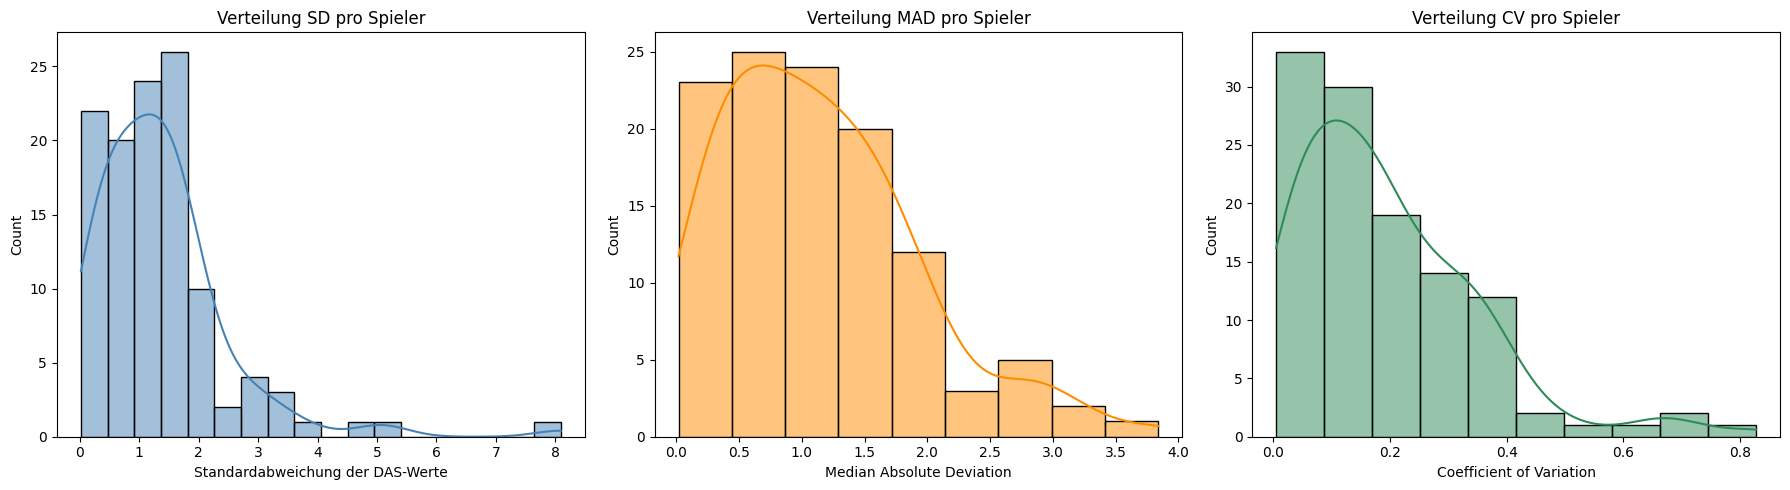

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(sd_vals, kde=True, ax=ax[0], color="steelblue")
ax[0].set_title("Verteilung SD pro Spieler")
ax[0].set_xlabel("Standardabweichung der DAS-Werte")

sns.histplot(mad_vals, kde=True, ax=ax[1], color="darkorange")
ax[1].set_title("Verteilung MAD pro Spieler")
ax[1].set_xlabel("Median Absolute Deviation")

sns.histplot(cv_vals, kde=True, ax=ax[2], color="seagreen")
ax[2].set_title("Verteilung CV pro Spieler")
ax[2].set_xlabel("Coefficient of Variation")

plt.tight_layout()
plt.show()


##### 1.B Stability Scores im Vergleich

/var/folders/0_/wbkxgyls58sfjry1gqd340gh0000gn/T/ipykernel_1598/2783973310.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_scores, x="measure", y="stability", palette="viridis")


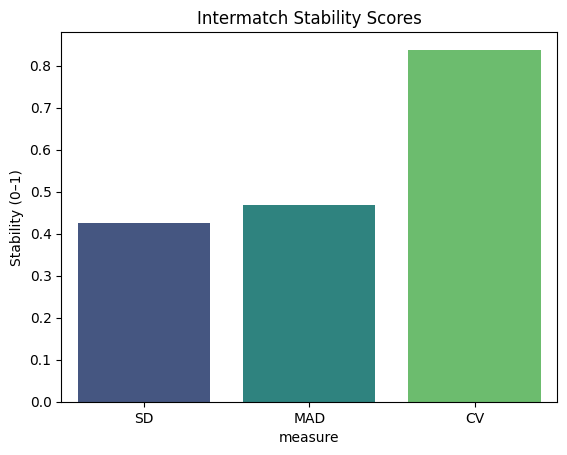

In [56]:
stability_scores = pd.DataFrame({
    "measure": ["SD", "MAD", "CV"],
    "stability": [sd_score, mad_score, cv_score]
})

sns.barplot(data=stability_scores, x="measure", y="stability", palette="viridis")
plt.title("Intermatch Stability Scores")
plt.ylabel("Stability (0–1)")
plt.show()


##### 1.C Spieler Stabilität vs. Mittelwert

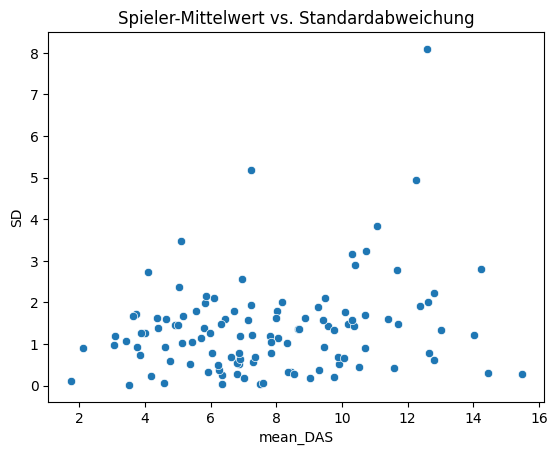

In [57]:
player_means = df_game.groupby("id")["DAS_potential_percentage"].mean()

df_sd_plot = pd.DataFrame({
    "mean_DAS": player_means,
    "SD": sd_vals
}).dropna()

sns.scatterplot(data=df_sd_plot, x="mean_DAS", y="SD")
plt.title("Spieler-Mittelwert vs. Standardabweichung")
plt.show()


#### 2. Intramatch-Stability

##### 2.A Scatterplot Halbzeit 1 vs. Halbzeit 2

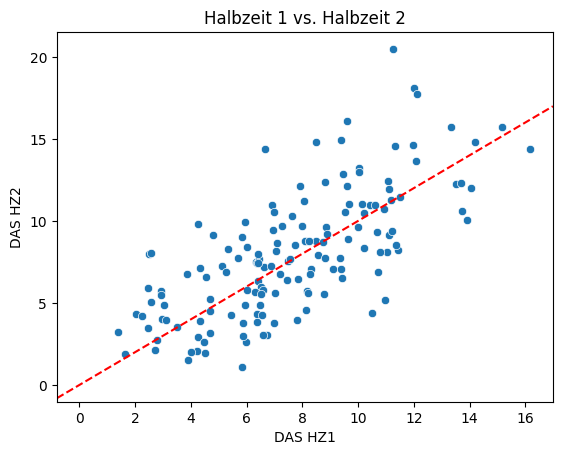

In [58]:
sns.scatterplot(data=df_hz, x="HZ1", y="HZ2")
plt.title("Halbzeit 1 vs. Halbzeit 2")
plt.xlabel("DAS HZ1")
plt.ylabel("DAS HZ2")
plt.axline((0, 0), slope=1, color="red", linestyle="--")
plt.show()


##### 2.B Bland-Altman Plot

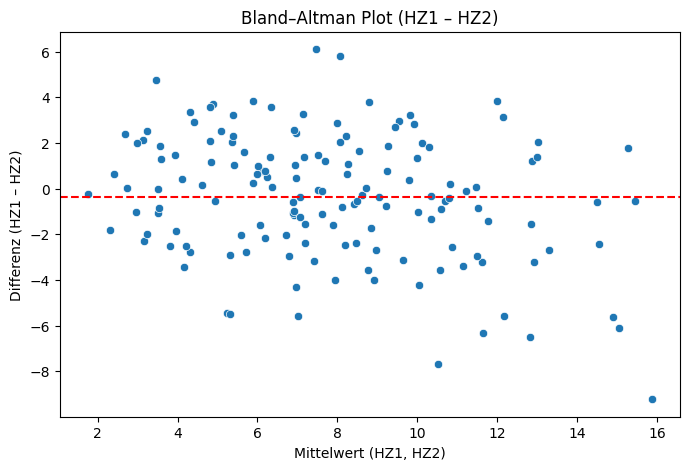

In [59]:
mean_vals = df_hz.mean(axis=1)
diff_vals = df_hz["HZ1"] - df_hz["HZ2"]

plt.figure(figsize=(8,5))
sns.scatterplot(x=mean_vals, y=diff_vals)
plt.axhline(diff_vals.mean(), color="red", linestyle="--")
plt.title("Bland–Altman Plot (HZ1 – HZ2)")
plt.xlabel("Mittelwert (HZ1, HZ2)")
plt.ylabel("Differenz (HZ1 – HZ2)")
plt.show()


#### 3. Externe Validierung

##### 3.A Scatterplot mit Regressionslinie

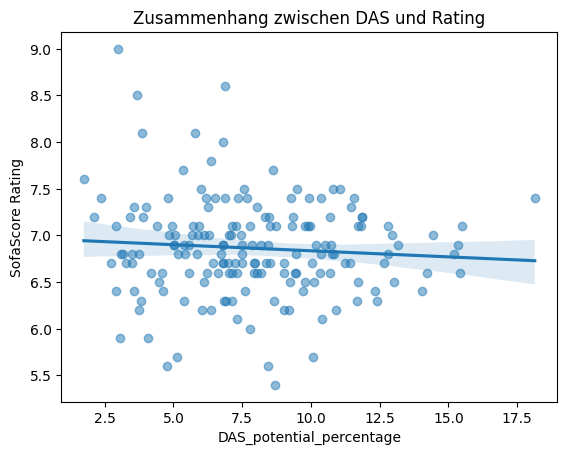

In [61]:
sns.regplot(
    data=merged_ratings, 
    x="DAS_potential_percentage", 
    y="SofaScore Rating", 
    scatter_kws={"alpha":0.5}
)
plt.title("Zusammenhang zwischen DAS und Rating")
plt.show()


##### 3.B Heatmap der Korrelationen

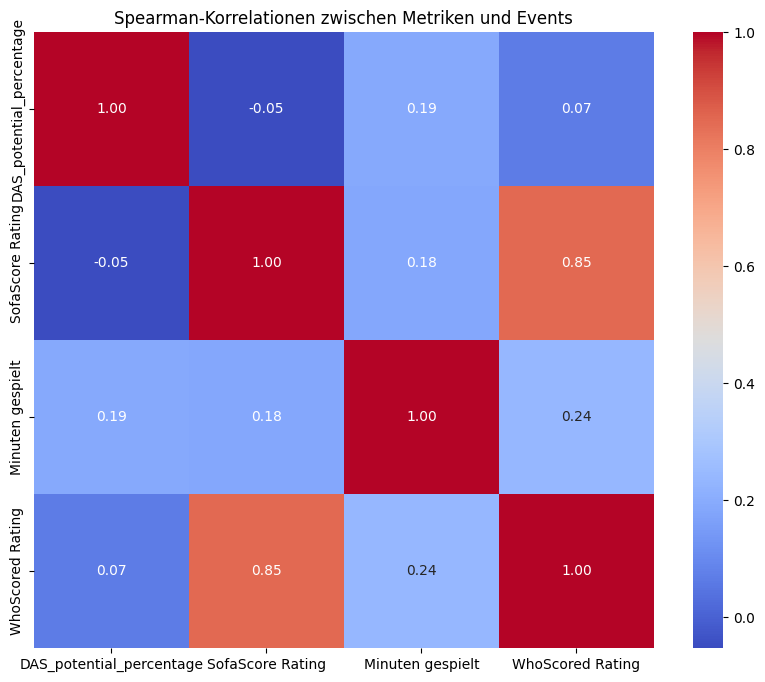

In [64]:
corr_matrix = merged_ratings.corr(method="spearman", numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman-Korrelationen zwischen Metriken und Events")
plt.show()


#### 4. Effect Sizes

##### 4.A Boxplot Top vs Bottom Player Effect Sizes

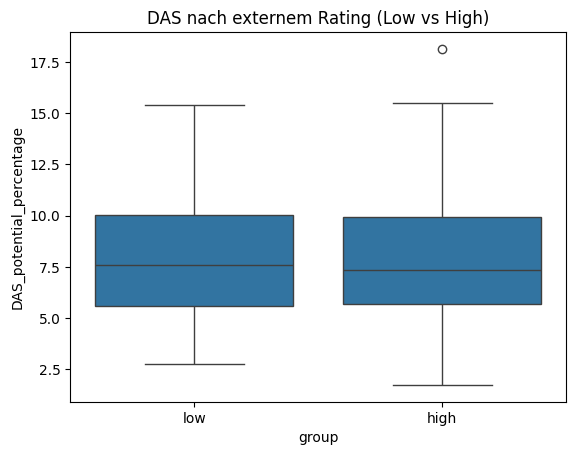

In [67]:
merged_ratings["group"] = pd.qcut(merged_ratings["SofaScore Rating"], 2, labels=["low","high"])

sns.boxplot(data=merged_ratings, x="group", y="DAS_potential_percentage")
plt.title("DAS nach externem Rating (Low vs High)")
plt.show()


#### 5. ICC-Visualisierung

##### 5.A Barplot Between vs Within Variance ICC

/var/folders/0_/wbkxgyls58sfjry1gqd340gh0000gn/T/ipykernel_1598/2856289249.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_var, x="component", y="variance", palette="pastel")


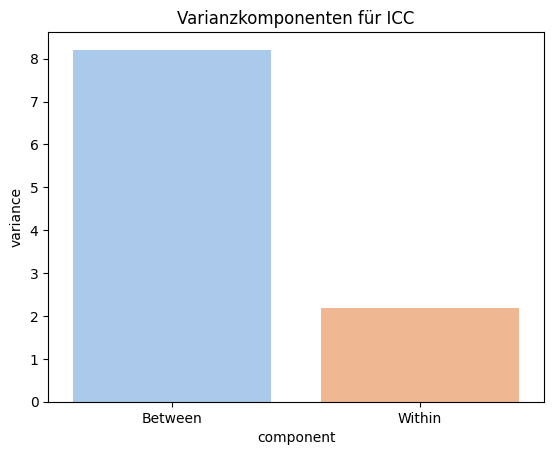

In [68]:
vals = df_balanced["DAS_potential_percentage"]
groups = df_balanced["id"]

grand_mean = vals.mean()
group_means = vals.groupby(groups).mean()

var_between = ((group_means - grand_mean)**2).mean()
var_within = vals.groupby(groups).apply(lambda x: ((x - x.mean())**2).mean()).mean()

df_var = pd.DataFrame({
    "component": ["Between", "Within"],
    "variance": [var_between, var_within]
})

sns.barplot(data=df_var, x="component", y="variance", palette="pastel")
plt.title("Varianzkomponenten für ICC")
plt.show()
